In [1]:
using LinearAlgebra, Test, SparseArrays, Plots, Parameters, OffsetArrays, DifferentialEquations, IterativeSolvers, LinearMaps
using Plots, BenchmarkTools, Traceur

In [2]:
# get Q in matrix form for sanity check
function get_Q_matrix(params)
    @unpack θ, cohorts, ts_cohort = params
    # intermediate vals
    N = cohorts[1]
    setsize = (N+1)^2;
    function get_row_block(d_i,a)  
        current_cohort = sum(a .>= ts_cohort) + 1
        N_total = current_cohort*N
       
        # note that all rows sum up to zero by construction
        # (outflow)
        dl_block = -(z->((N_total-z)/N_total)*θ(a)).(d_i:(d_i+N))
        if (d_i == N) # there's no diffusion to 2nd cohort in the last block
            dl_block = dl_block/current_cohort
        end
        
        # (inflow, not from forgetting)
        d_block = -(current_cohort == 2 && d_i == 2 ? 2 : 1)*dl_block/current_cohort
        du_block = -dl_block/current_cohort
        
        mat = spdiagm(0 => dl_block, 1 => d_block, (1+N)=>du_block) 
        
        # modify the last row, where first cohort products are fully recognized
        mat[(N+1),(N+2)] = 0.0
        mat[(N+1),end] *= current_cohort 
        mat[(N+1),:] /= current_cohort # if departure rate is halved for full recognized state
        
        # (outflow, from forgetting)
        mat -= spdiagm(0 => fill(μ, size(mat)[1]))
        if (d_i == 0) # at (0,0) there is no forgetting
            mat[1,1] += μ
        end
        # (inflow, from forgetting)
        forget_1 = fill(d_i == 0 || current_cohort == 1 ? μ : μ / 2, (size(mat)[1]-1)) # forget rate for 1st 
        forget_2 = spdiagm(0 => (current_cohort == 1 ? fill(0.0, N+1) : [μ; fill(μ/2,N)])) # forget rate for 2nd 
        mat += spdiagm(-1 => forget_1) 

        # fill the rest in row block with zeros    
        if (current_cohort == 1) # use only first block if used in
            mat = d_i == 0 ? [mat[:, 1:(N+1)] zeros(2*(N+1), N+1)] : similar(mat)   
        end
        if (d_i == 0)
            return [mat[1:(N+1),:] zeros(N+1, (N+1)*(N-1))]
        elseif (d_i == (N-1))
            return [zeros(N+1, (N-2)*(N+1)) forget_2 mat[1:(N+1),:]]
        elseif (d_i == N)
            return [zeros(N+1, (N-1)*(N+1)) forget_2 mat[1:(N+1),1:(N+1)]]
        else
            return [zeros(N+1, (d_i-1)*(N+1)) forget_2 mat[1:(N+1),:] zeros(N+1, (N-1-d_i)*(N+1))]
        end
    end
    # generate model
    return a -> vcat(get_row_block.(0:N, a)...)
end

# solve model with matrix Q
function solve_transition_dynamics_matrix(Q_matrix, f_0, T)
    # solve transition dynamics given 
    # Q; N by N matrix generator
    # f_0; N vector of initial distribution
    # T; Float64 terminal time
    df(f,p,a) = Q_matrix(a)' * f
    prob = DifferentialEquations.ODEProblem(df,f_0,(0.0,T))
    return solve(prob);
end


solve_transition_dynamics_matrix (generic function with 1 method)

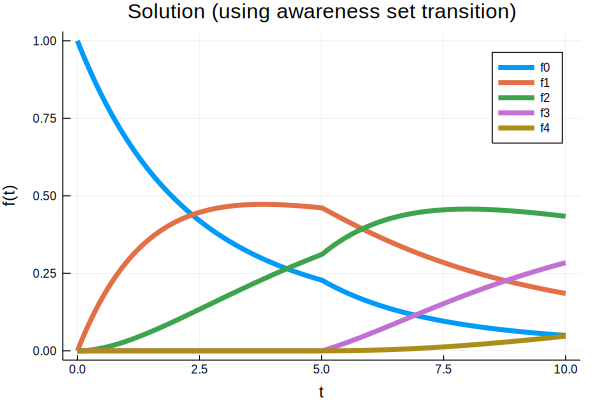

In [3]:
# two firms per cohort
t_2 = 5.0
θ_1 = 0.4
θ_2 = 0.6
θ(t) = t < t_2 ? θ_1 : θ_2
t = 0.0
N = 2
T = 10.0
μ = 0.1 # forgetting rate
cohorts = (N, N)
ts_cohort = [t_2]
params = (θ = θ, cohorts = cohorts, ts_cohort = ts_cohort, μ = μ)

# define generator
Q = get_Q_matrix(params)

# solve the corresponding ODE
f_0 = [1.0; fill(0.0, (N+1)^2-1)]
sol_awareness = solve_transition_dynamics_matrix(Q, f_0, T)

# convert to the counting solution
f0_awareness(a) = sol_awareness(a)[1] # no product
# 1.1 or 2.1
f1_awareness(a) = sol_awareness(a)[2] + sol_awareness(a)[4] 
# 1.1+1.2 or 1.1+2.1 or 2.1+2.2
f2_awareness(a) = sol_awareness(a)[3] + sol_awareness(a)[5] + sol_awareness(a)[7]
# 1.1+1.2+2.1 or 1.1+2.1+2.2
f3_awareness(a) = sol_awareness(a)[6] + sol_awareness(a)[8] 
# 1.1+1.2+2.1+2.2
f4_awareness(a) = sol_awareness(a)[9]

# plot
plot(0:0.01:T, [f0_awareness, f1_awareness, f2_awareness, f3_awareness, f4_awareness],linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2" "f3" "f4"])

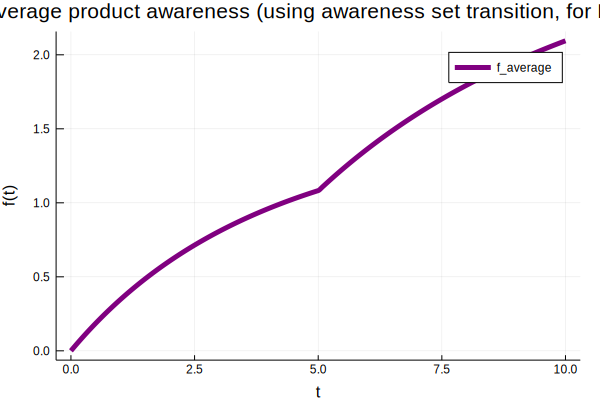

In [4]:
if (N == 2)
   f_awareness(a) = dot(0:2*N, [f0_awareness(a); f1_awareness(a); f2_awareness(a); f3_awareness(a); f4_awareness(a)]) # average product awareness
   plot(0:0.01:T, f_awareness, linewidth=5,
        title="Average product awareness (using awareness set transition, for N = 2)",
        xaxis="t",yaxis="f(t)",label=["f_average"],linecolor="purple") 
end

In [5]:
# sanity checks
# all row sum should be zero
@test Q(0.0)*ones((N+1)^2,1) ≈ fill(0.0, (N+1)^2) atol = 1e-2

# check if f is a probability distribution for all t in (0, T)
@test all(sum.(sol_awareness.(0:0.1:T)) .≈ 1.0)

Test Passed

# Using matrix free operators

In [6]:
using DiffEqOperators 
# solve model without matrix
function solve_transition_dynamics(O!, params, f_0, T; dt = 0.25)
    # unpack params
    @unpack θ, cohorts, ts_cohort, μ = params
    N = cohorts[1] # assume that N_t is invariant across all t
        
    # definte the corresponding ODE problem
    prob = ODEProblem(O!,f_0,(0.0,T), params)
    
    # solve the model
#     solve(prob, LinearExponential(krylov=:simple), tstops=union(0:dt:T, ts_cohort, T))
    solve(prob, HochOst4(krylov=true), dt=0.1)
end

solve_transition_dynamics (generic function with 1 method)

In [7]:
# methods for testing
function sanity_check(Q_a!, params)
    # define the corresponding operator
    N = params.cohorts[1] # assume that N_t is invariant across all t
    K = length(params.cohorts) # number of cohorts
    setsize = (N+1)^K;
    O! = MatrixFreeOperator(Q_a!, (params, 0.0))

    # solve the corresponding ODE
    sol_awareness_matrix_free = solve_transition_dynamics(O!, params, f_0, T)
 
    # convert to the counting solution
    indices = CartesianIndices(reshape(1:setsize, Tuple(fill(0:N, K))))
    counts = (x -> sum(indices[x])).(1:setsize) # index to count size

    f0_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 0]) # no product
    f1_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 1]) # 1 product
    f2_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 2]) # 2 products
    f3_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 3]) # 3 products
    f4_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 4]) # 4 products
    
    # check if they yield very close results
    @test f0_awareness.(0:0.1:T) ≈ f0_awareness_matrix_free.(0:0.1:T) atol=1e-1
    @test f1_awareness.(0:0.1:T) ≈ f1_awareness_matrix_free.(0:0.1:T) atol=1e-1
    @test f2_awareness.(0:0.1:T) ≈ f2_awareness_matrix_free.(0:0.1:T) atol=1e-1
    @test f3_awareness.(0:0.1:T) ≈ f3_awareness_matrix_free.(0:0.1:T) atol=1e-1
    @test f4_awareness.(0:0.1:T) ≈ f4_awareness_matrix_free.(0:0.1:T) atol=1e-1
end

sanity_check (generic function with 1 method)

## Vanilla implmentation

In [8]:
# helper function for sum of cartesian indices
import Base.sum
sum(I::CartesianIndex) = sum(Tuple(I))
subtract_by_one(I::CartesianIndex, i::Int64, length::Int64) = I - unit_vector(i, length)
add_by_one(I::CartesianIndex, i::Int64, length::Int64) = I + unit_vector(i, length)
function unit_vector(i::Int64, length::Int64)
   v = fill(0, length)
   v[i] = 1
   return CartesianIndex(Tuple(v))
end
# method
function Q_a!(df, f, p, t)
    # unpack params
    @unpack θ, cohorts, ts_cohort, μ = p
    N = cohorts[1] # assume that N_t is invariant across all t
    K = length(cohorts) # number of cohorts
    setsize = (N+1)^K;
    
    f = reshape(f, Tuple(fill(0:N, K)))
    df = reshape(df, Tuple(fill(0:N, K)))
    θ_t = θ(t)
    current_cohort = sum(t .> ts_cohort) + 1
    N_total = current_cohort*N;
    
    for i in CartesianIndices(f)
        # (outflow)
        full_aware_ratio = sum(Tuple(i) .== N) / current_cohort # ratio of cohorts fully awared
        any_aware_count = sum(Tuple(i) .!= 0) # number of cohorts that aren't zero
        df[i] = -(((N_total - sum(i)) / N_total) * θ_t * (1-full_aware_ratio) + μ) * f[i]

        # (inflow)
        for cohort in 1:current_cohort
            # if the current status has some awareness in a cohort
            # then there's in-flow from past in the cohort
            if (i[cohort] > 0)  
                i_past = subtract_by_one(i, cohort, K) 
                df[i] += ((N_total + 1 - sum(i)) / N_total) * (θ_t / current_cohort) * f[i_past]
            end
            # if the current status has no full-awareness in a cohort
            # then there's in-flow from more-awared status from the cohort source by forgetting
            if (i[cohort] < N) 
                # Inflow amount depends on the current status:
                # 1.1.2 can be from 2.1.2 and 1.2.2; 
                # note that the inflow from each case is μ/3
                # 1.1.1 can be from 2.1.1 and 1.2.1 and 1.1.2
                # note that the inflow from each case is μ/3 
                # 0.0.1 can be from 1.0.1 and 0.1.1 and 0.0.2
                # note that the inflow from case 1 is μ/2 while case 2/3 is μ
                # from source state forgetting is dispersed by any_aware_count_in_source_state
                # which is (any_aware_count + (i[cohort] == 0)) in the current state because 
                # if i[cohort] == 0 then the source state has any_aware_count + 1 (1 from cohort)
                # if i[cohort] != 0 then the source state has any_aware_count 
                # (since the source state has i[cohort] > 0)
                i_future = add_by_one(i, cohort, K)
                df[i] += μ / (any_aware_count + (i[cohort] == 0)) * f[i_future]
            end
        end
    end
    df[1] += μ * f[1] # there is no forgetting in the state where no product is recognized
end

Q_a! (generic function with 1 method)

In [9]:
df = similar(f_0)
f = deepcopy(f_0)
@btime Q_a!(df, f, params, 0.0)
sanity_check(Q_a!, params)

  18.285 μs (360 allocations: 14.42 KiB)


Test Passed

## + Preallocation for `full_aware_count` and `any_aware_count`

In [10]:
# getting some params
N = params.cohorts[1] # assume that N_t is invariant across all t
K = length(params.cohorts) # number of cohorts
setsize = (N+1)^K;
indices = CartesianIndices(reshape(f_0, Tuple(fill(0:N, K))))

# helper function for sum of cartesian indices
import Base.sum
sum(I::CartesianIndex) = sum(Tuple(I))
subtract_by_one(I::CartesianIndex, i::Int64, length::Int64) = I - unit_vector(i, length)
add_by_one(I::CartesianIndex, i::Int64, length::Int64) = I + unit_vector(i, length)
full_aware_counts = (i -> sum(Tuple(indices[i]) .== N)).(1:setsize) # number of cohorts that are fully awared
any_aware_counts = (i ->  sum(Tuple(indices[i]) .!= 0)).(1:setsize) # number of cohorts that aren't zero
params = merge(params, (full_aware_counts = full_aware_counts, any_aware_counts = any_aware_counts))
function unit_vector(i::Int64, length::Int64)
   v = fill(0, length)
   v[i] = 1
   return CartesianIndex(Tuple(v))
end
# method
function Q_a!(df, f, p, t)
    # unpack params
    @unpack θ, cohorts, ts_cohort, μ, full_aware_counts, any_aware_counts = p
    N = cohorts[1] # assume that N_t is invariant across all t
    K = length(cohorts) # number of cohorts
    setsize = (N+1)^K;
    
    f = reshape(f, Tuple(fill(0:N, K)))
    df = reshape(df, Tuple(fill(0:N, K)))
    θ_t = θ(t)
    current_cohort = sum(t .> ts_cohort) + 1
    N_total = current_cohort*N;
    indices = CartesianIndices(f)
    
    for i_order in 1:setsize
        i = indices[i_order] # extract Cartesian index
        # (outflow)
        full_aware_ratio = full_aware_counts[i_order] / current_cohort # ratio of cohorts fully awared
        df[i] = -(((N_total - sum(i)) / N_total) * θ_t * (1-full_aware_ratio) + μ) * f[i]
        # (inflow)
        for cohort in 1:current_cohort
            # if the current status has some awareness in a cohort
            # then there's in-flow from past in the cohort
            if (i[cohort] > 0)  
                i_past = subtract_by_one(i, cohort, K) 
                df[i] += ((N_total + 1 - sum(i)) / N_total) * (θ_t / current_cohort) * f[i_past]
            end
            # if the current status has no full-awareness in a cohort
            # then there's in-flow from more-awared status from the cohort source by forgetting
            if (i[cohort] < N) 
                # Inflow amount depends on the current status:
                # 1.1.2 can be from 2.1.2 and 1.2.2; 
                # note that the inflow from each case is μ/3
                # 1.1.1 can be from 2.1.1 and 1.2.1 and 1.1.2
                # note that the inflow from each case is μ/3 
                # 0.0.1 can be from 1.0.1 and 0.1.1 and 0.0.2
                # note that the inflow from case 1 is μ/2 while case 2/3 is μ
                # from source state forgetting is dispersed by any_aware_count_in_source_state
                # which is (any_aware_count + (i[cohort] == 0)) in the current state because 
                # if i[cohort] == 0 then the source state has any_aware_count + 1 (1 from cohort)
                # if i[cohort] != 0 then the source state has any_aware_count 
                # (since the source state has i[cohort] > 0)
                i_future = add_by_one(i, cohort, K)
                df[i] += μ / (any_aware_counts[i_order] + (i[cohort] == 0)) * f[i_future]
            end
        end
    end
    df[1] += μ * f[1] # there is no forgetting in the state where no product is recognized
end

Q_a! (generic function with 1 method)

In [11]:
df = similar(f_0)
f = deepcopy(f_0)
@btime Q_a!(df, f, params, 0.0)
sanity_check(Q_a!, params)

  10.586 μs (270 allocations: 11.75 KiB)


Test Passed

## + Preallocation for `aware_count`

In [12]:
# getting some params
N = params.cohorts[1] # assume that N_t is invariant across all t
K = length(params.cohorts) # number of cohorts
setsize = (N+1)^K;
indices = CartesianIndices(reshape(f_0, Tuple(fill(0:N, K))))

# helper function for sum of cartesian indices
import Base.sum
sum(I::CartesianIndex) = sum(Tuple(I))
subtract_by_one(I::CartesianIndex, i::Int64, length::Int64) = I - unit_vector(i, length)
add_by_one(I::CartesianIndex, i::Int64, length::Int64) = I + unit_vector(i, length)
full_aware_counts = (i -> sum(Tuple(indices[i]) .== N)).(1:setsize) # number of cohorts that are fully awared
any_aware_counts = (i -> sum(Tuple(indices[i]) .!= 0)).(1:setsize) # number of cohorts that aren't zero
aware_counts = (i -> sum(Tuple(indices[i]))).(1:setsize) # number of products awared
params = merge(params, (full_aware_counts = full_aware_counts, any_aware_counts = any_aware_counts, aware_counts = aware_counts))
function unit_vector(i::Int64, length::Int64)
   v = fill(0, length)
   v[i] = 1
   return CartesianIndex(Tuple(v))
end
# method
function Q_a!(df, f, p, t)
    # unpack params
    @unpack θ, cohorts, ts_cohort, μ, full_aware_counts, any_aware_counts, aware_counts = p
    N = cohorts[1] # assume that N_t is invariant across all t
    K = length(cohorts) # number of cohorts
    setsize = (N+1)^K;
    
    f = reshape(f, Tuple(fill(0:N, K)))
    df = reshape(df, Tuple(fill(0:N, K)))
    θ_t = θ(t)
    current_cohort = sum(t .> ts_cohort) + 1
    N_total = current_cohort*N;
    indices = CartesianIndices(f)
    
    for i_order in 1:setsize
        i = indices[i_order] # extract Cartesian index
        # (outflow)
        full_aware_ratio = full_aware_counts[i_order] / current_cohort # ratio of cohorts fully awared
        df[i] = -(((N_total - aware_counts[i_order]) / N_total) * θ_t * (1-full_aware_ratio) + μ) * f[i]
        # (inflow)
        for cohort in 1:current_cohort
            # if the current status has some awareness in a cohort
            # then there's in-flow from past in the cohort
            if (i[cohort] > 0)  
                i_past = subtract_by_one(i, cohort, K) 
                df[i] += ((N_total + 1 - aware_counts[i_order]) / N_total) * (θ_t / current_cohort) * f[i_past]
            end
            # if the current status has no full-awareness in a cohort
            # then there's in-flow from more-awared status from the cohort source by forgetting
            if (i[cohort] < N) 
                # Inflow amount depends on the current status:
                # 1.1.2 can be from 2.1.2 and 1.2.2; 
                # note that the inflow from each case is μ/3
                # 1.1.1 can be from 2.1.1 and 1.2.1 and 1.1.2
                # note that the inflow from each case is μ/3 
                # 0.0.1 can be from 1.0.1 and 0.1.1 and 0.0.2
                # note that the inflow from case 1 is μ/2 while case 2/3 is μ
                # from source state forgetting is dispersed by any_aware_count_in_source_state
                # which is (any_aware_count + (i[cohort] == 0)) in the current state because 
                # if i[cohort] == 0 then the source state has any_aware_count + 1 (1 from cohort)
                # if i[cohort] != 0 then the source state has any_aware_count 
                # (since the source state has i[cohort] > 0)
                i_future = add_by_one(i, cohort, K)
                df[i] += μ / (any_aware_counts[i_order] + (i[cohort] == 0)) * f[i_future]
            end
        end
    end
    df[1] += μ * f[1] # there is no forgetting in the state where no product is recognized
end

Q_a! (generic function with 1 method)

In [13]:
df = similar(f_0)
f = deepcopy(f_0)
@btime Q_a!(df, f, params, 0.0)
sanity_check(Q_a!, params)

  9.944 μs (276 allocations: 11.84 KiB)


Test Passed